Le score de silhouette moyen est : 0.6725


Segment  Nombre_de_Clients  Montant_Total_Moyen  Montant_Total  \
0       Client Fidèle                 51         3.943614e+09   2.011243e+11   
1  Client Occasionnel                136         3.526608e+08   4.796186e+10   
2      Client Premium                  1         3.621144e+11   3.621144e+11   
3     Client Prospect                  3         5.048179e+10   1.514454e+11   
4  Client à Potentiel                  7         2.421874e+10   1.695312e+11   

   Montant_Moyen  Nombre_Moyen_de_Transactions  \
0   7.639567e+07                     48.137255   
1   3.255360e+07                      5.742647   
2   1.061919e+09                    341.000000   
3   1.211656e+09                     52.333333   
4   6.390065e+07                    377.428571   

   Frequence_Moyenne_des_Transactions  Nombre_Moyen_d_Annees_Actives  
0                            4.176471                       4.333333  
1                            1.308824                       1.308824  
2                            5.000000                       5.000000  
3                            3.666667                       4.000000  
4                            5.000000                       5.000000

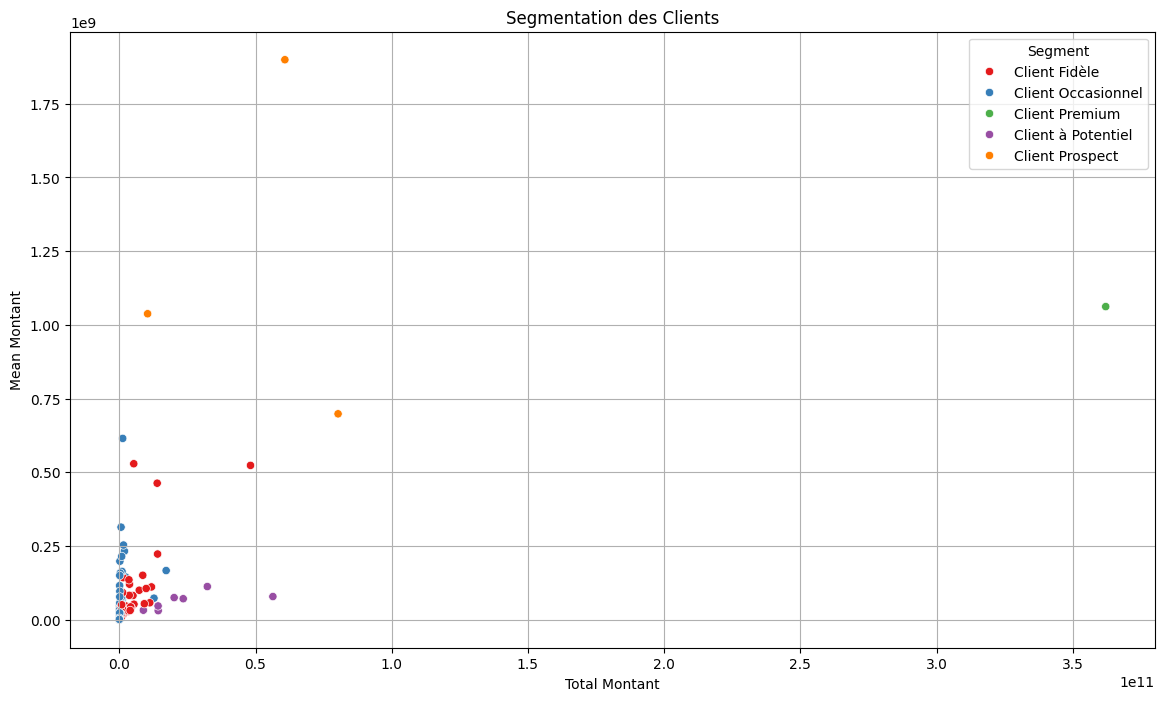

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les données
file_path = 'Remdoc New.csv'
data = pd.read_csv(file_path, delimiter=';', encoding='utf-8')

# Renommer les colonnes pour enlever les espaces
data.rename(columns=lambda x: x.strip(), inplace=True)

# Convertir les dates en format datetime
data['DVA'] = pd.to_datetime(data['DVA'], format='%d/%m/%Y')

# Ajouter une colonne pour l'année
data['year'] = data['DVA'].dt.year

# Calculer les caractéristiques pour chaque client
client_features = data.groupby('NOM').agg(
    Total_Montant=('MT_LOC', 'sum'),
    Mean_Montant=('MT_LOC', 'mean'),
    Nb_Transactions=('NDOS', 'count'),
    Freq_Transactions=('year', 'nunique'),
    Annees_Actives=('year', lambda x: x.max() - x.min() + 1)
).reset_index()

# Normaliser les données
scaler = StandardScaler()
client_features_scaled = scaler.fit_transform(client_features[['Total_Montant', 'Mean_Montant', 'Nb_Transactions', 'Freq_Transactions', 'Annees_Actives']])

# Appliquer K-means avec 5 clusters (optimal selon le score de silhouette)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
client_features['Cluster'] = kmeans.fit_predict(client_features_scaled)

# Calculer le score de silhouette
silhouette_avg = silhouette_score(client_features_scaled, client_features['Cluster'])
print(f"Le score de silhouette moyen est : {silhouette_avg:.4f}")

# Réassigner les noms marketing aux clusters
cluster_names = {
    0: 'Client Fidèle',     # Clients avec un montant moyen modéré, un nombre modéré de transactions, une fréquence de transactions modérée, plusieurs années actives
    1: 'Client Occasionnel',# Clients avec un montant total modéré, un nombre moyen de transactions, une fréquence de transactions sporadique, et plusieurs années actives
    2: 'Client Premium',    # Clients avec un montant total élevé, un montant moyen élevé, un nombre élevé de transactions, une fréquence élevée, et plusieurs années actives
    3: 'Client Prospect',   # Clients avec un montant total très élevé, un nombre très élevé de transactions, une fréquence et des années actives élevées
    4: 'Client à Potentiel' # Clients avec des transactions en croissance, un potentiel de devenir des clients plus actifs
}

# Attribuer les noms marketing aux clusters
client_features['Segment'] = client_features['Cluster'].map(cluster_names)


# Calculer les statistiques descriptives pour chaque segment
segment_analysis = client_features.groupby('Segment').agg(
    Nombre_de_Clients=('NOM', 'count'),
    Montant_Total_Moyen=('Total_Montant', 'mean'),
    Montant_Total=('Total_Montant', 'sum'),
    Montant_Moyen=('Mean_Montant', 'mean'),
    Nombre_Moyen_de_Transactions=('Nb_Transactions', 'mean'),
    Frequence_Moyenne_des_Transactions=('Freq_Transactions', 'mean'),
    Nombre_Moyen_d_Annees_Actives=('Annees_Actives', 'mean')
).reset_index()

# Afficher les résultats sous forme de tableau
display(segment_analysis)



# Visualisation des clusters avec des couleurs différentes
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Total_Montant', y='Mean_Montant', hue='Segment', data=client_features, palette='Set1')
plt.title('Segmentation des Clients')
plt.xlabel('Total Montant')
plt.ylabel('Mean Montant')
plt.legend(title='Segment')
plt.grid(True)
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_23380\3429140974.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_clients_per_segment = client_features.groupby('Segment').apply(
C:\Users\user\AppData\Local\Temp\ipykernel_23380\3429140974.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Montant', y='NOM', data=segment_data, ax=ax, palette=[palette[i]])
C:\Users\user\AppData\Local\Temp\ipykernel_23380\3429140974.py:19: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpr

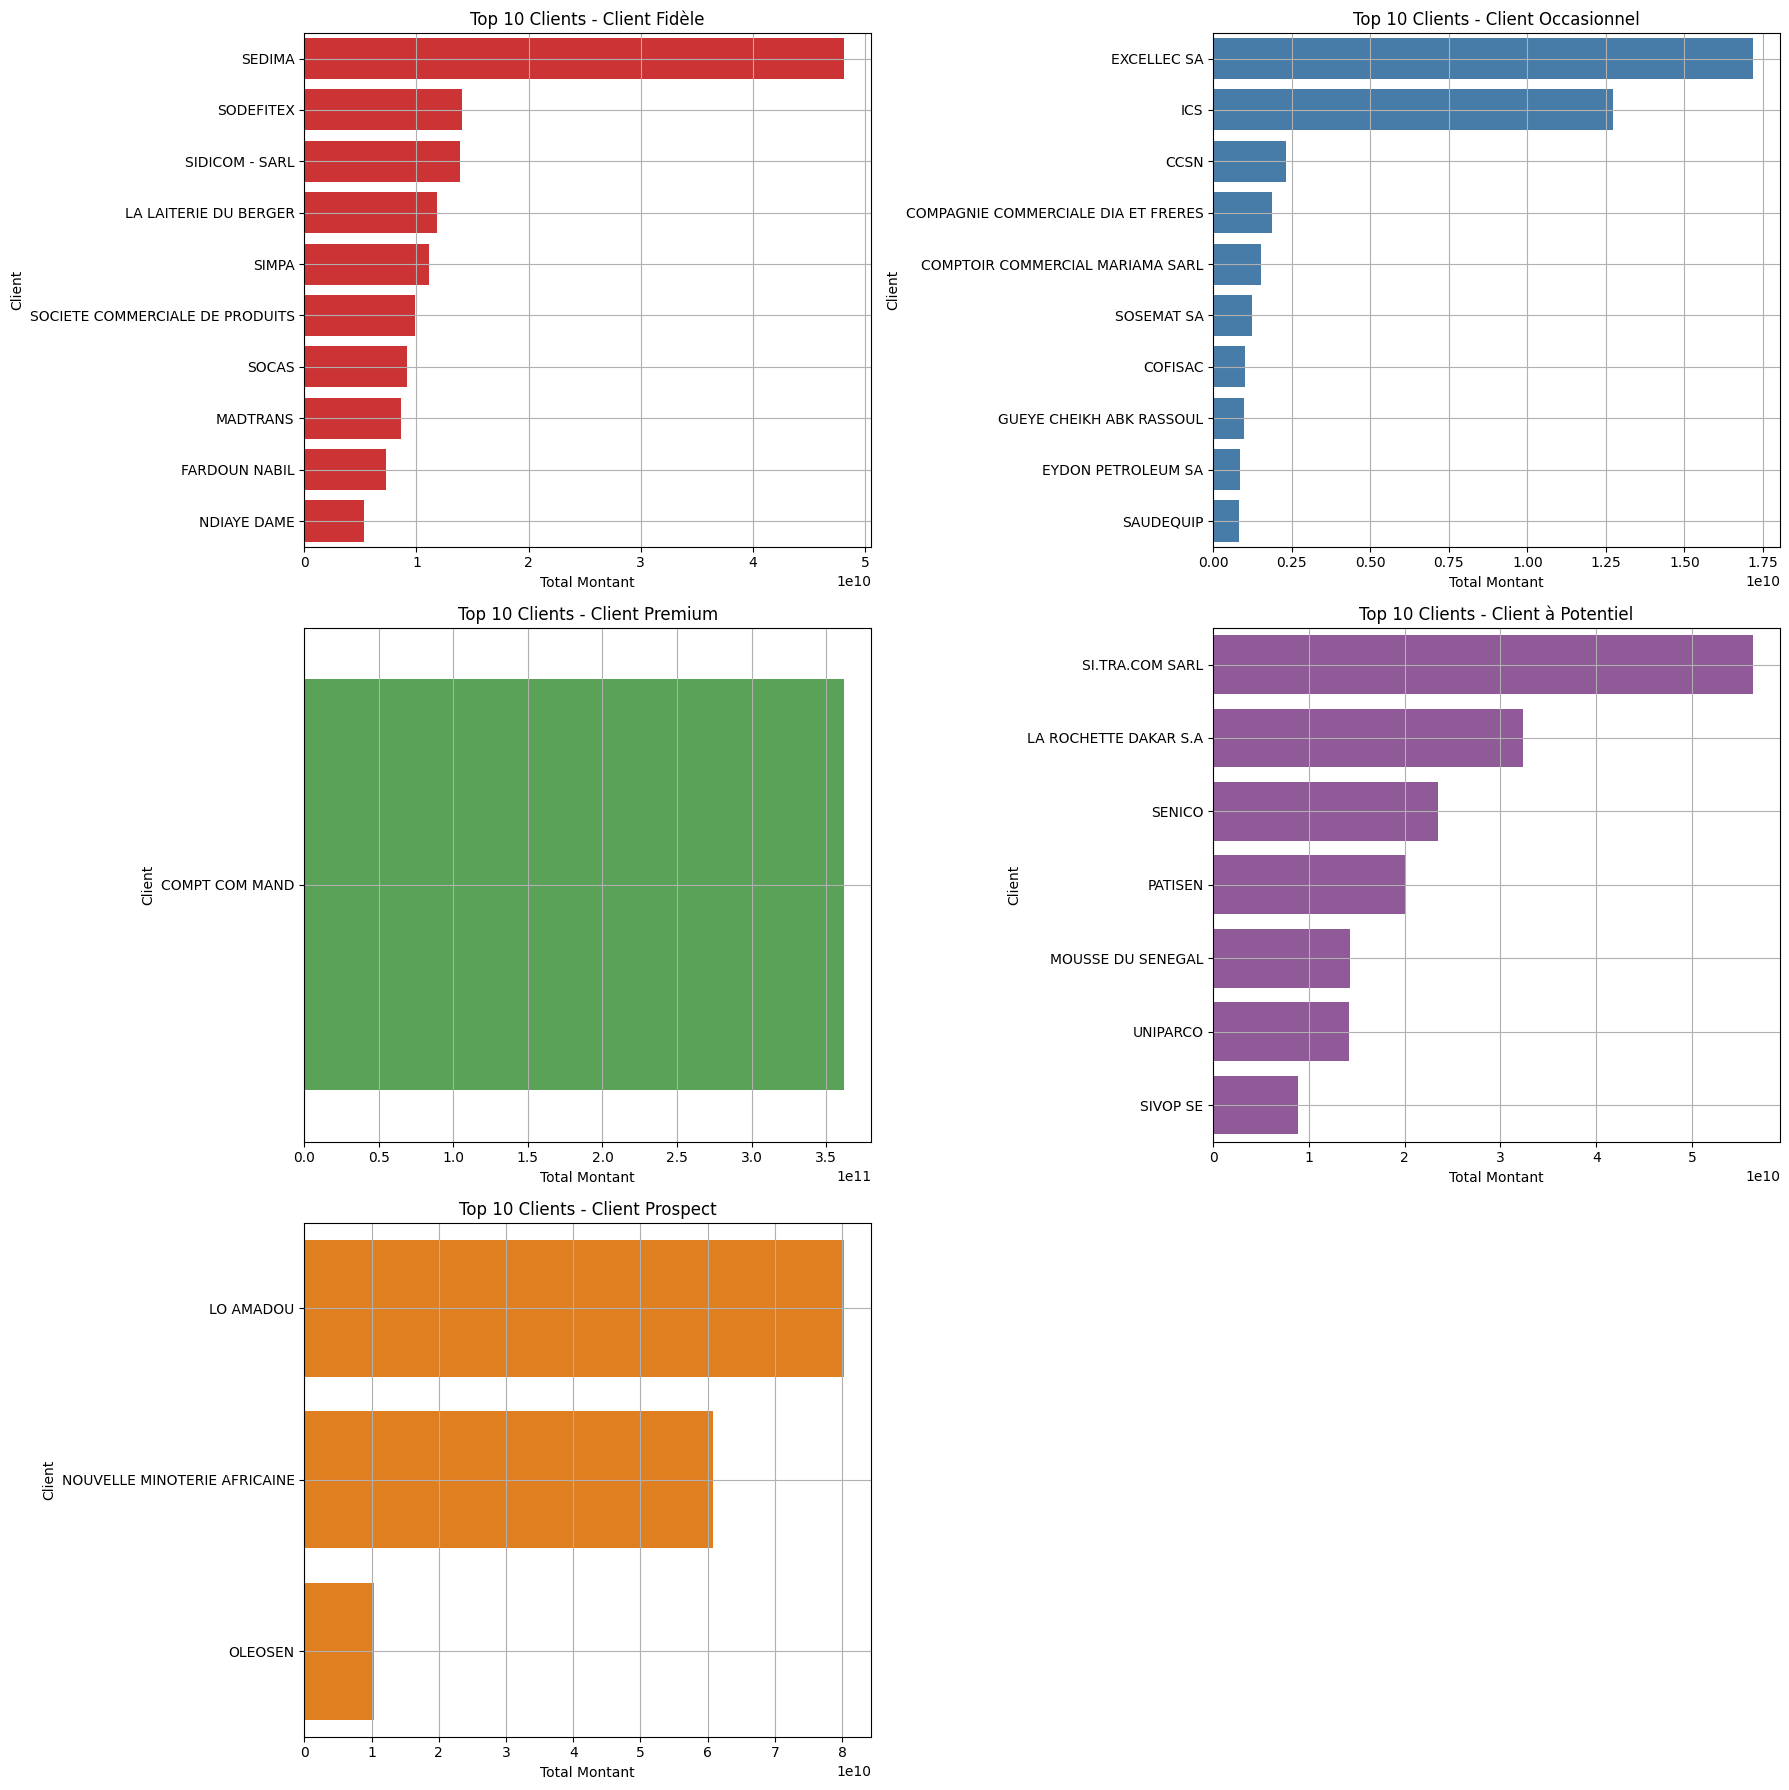

In [14]:
# Identifier le Top 10 clients pour chaque segment
top_10_clients_per_segment = client_features.groupby('Segment').apply(
    lambda x: x.nlargest(10, 'Total_Montant')
).reset_index(drop=True)

# Créer des sous-graphiques pour chaque segment
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# Liste des segments pour itérer
segments = client_features['Segment'].unique()

# Palette de couleurs pour les segments
palette = sns.color_palette('Set1', len(segments))

# Créer des sous-graphiques pour chaque segment
for i, segment in enumerate(segments):
    ax = axes[i // 2, i % 2]
    segment_data = top_10_clients_per_segment[top_10_clients_per_segment['Segment'] == segment]
    sns.barplot(x='Total_Montant', y='NOM', data=segment_data, ax=ax, palette=[palette[i]])
    ax.set_title(f'Top 10 Clients - {segment}')
    ax.set_xlabel('Total Montant')
    ax.set_ylabel('Client')
    ax.grid(True)

# Supprimer le sous-graphe vide s'il y a un nombre impair de segments
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()